In [58]:
from typing import List, Dict, Tuple, Callable
import itertools
import math
import os
import pickle
from copy import deepcopy

import casadi as cas
import numpy as np
from scipy import signal
from dataclasses import dataclass
import matplotlib.pyplot as plt

from IOData.IOData import IOData, InputRule
from IOData.IODataWith_l import IODataWith_l
from System.ErrorKinematicAcceLATI import LinearizedErrorKinematicAcceModel, LinearizedErrorKinematicAcceModelParams, KinematicAcceModelParams
from tools.simualtion_results import Results, PlotStyle
from tools.dataset_analyse import get_datasets_hankel_matrix

In [59]:
def fractal_dimension(
        locs: np.ndarray, region_min: np.ndarray, region_max: np.ndarray,
        max_box_size: float = None, min_box_size: float = -3.0,
        n_samples: int = 20, n_offsets: float = 0, plot = False) -> Tuple[float, np.ndarray, np.ndarray]:
    """Calculates the fractal dimension of a 3D numpy array.
    Returns: 
        float: the fractal dimension
        np.ndarray: the log of the number of boxes N(s) needed to cover the graph
        np.ndarray: the log of the inverse of the box size 1/s

    Args:
        locs (np.ndarray): locations where the graph is marked as 1. 
                            Of the form [[point1], [point2], ...]
        region_min (np.ndarray): minimum values of the region of interest.
        region_max (np.ndarray): maximum values of the region of interest.
        max_box_size (float): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (float): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (float): number of offsets to search over to find the smallest set N(s) to
                       cover  all voxels>0.
        plot (bool): set to true to see the analytical plot of a calculation.
                            
        
    """
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = np.log2(np.min(region_max - region_min))
    scales = np.logspace(max_box_size, min_box_size, num=n_samples, base=2)
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(min_el-offset, max_el+scale, scale) for min_el, max_el in zip(region_min, region_max)]
            H1, e = np.histogramdd(locs, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log2(1/scales), np.log2(Ns),1)
    
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log2(1/scales), np.log2(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel(r"$\log_2 N(\epsilon)$")
        ax.set_xlabel(r"$\log_2 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log2(1/scales))
        ax.plot(np.log2(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend()
    
    return coeffs[0], np.log2(Ns), np.log2(1/scales)

In [60]:
class DoubleIntegratorWithDrag:
    _state: np.ndarray # actual state of the system, [x, dot_x]
    @property
    def state(self):
        return self._state
    @state.setter
    def state(self, state: np.ndarray):
        self._state = state

    _x: cas.SX # state vector of system
    _u: cas.SX # input vector of system
    _f: cas.SX # dynamics of system
    _F_c_r: cas.Function # casadi integrator for the ode function

    Ts: float # sampling time of system
    beta: float # drag coefficient of system

    u_min: float # minimum input of system
    u_max: float # maximum input of system

    x_min: np.ndarray # minimum state of system
    x_max: np.ndarray # maximum state of system

    @property
    def m(self):
        return 1
    
    @property
    def n(self):
        return 2
    
    @property
    def p(self):
        return 2
    
    @property
    def A_u(self):
        return np.matrix("1;-1")
    
    @property
    def b_u(self):
        return np.matrix([[self.u_max],[-self.u_min]])
    
    @property
    def A_y(self):
        return np.matrix("1 0; 0 1; -1 0; 0 -1")
    
    @property
    def b_y(self):
        return np.matrix([[self.x_max[0]], [self.x_max[1]], [-self.x_min[0]], [-self.x_min[1]]])

    def __init__(self, Ts: float, beta: float, g: float,
                 init_state: np.ndarray = np.array([0, 0]),
                 u_min: float = -1, u_max: float = 1,
                 x_min: np.ndarray = np.array([-np.inf, -np.inf]),
                 x_max: np.ndarray = np.array([np.inf, np.inf])):
        self.Ts = Ts
        self.g = g
        self.beta = beta
        self._state = init_state
        self.u_min = u_min
        self.u_max = u_max
        self.x_min = x_min
        self.x_max = x_max

        self._x = cas.SX.sym('x', 2)
        self._u = cas.SX.sym('u', 1)
        self._f = cas.SX.sym('f', 2)

        self._f[0] = 3 * self._x[1]
        self._f[1] = self._u[0] - self.g * cas.sin(self._x[0]) - self.beta * cas.cos(10*self._x[1]**2) ** 2 * self._x[0]
        # self._f[1] = self._u[0]

        ode = {'x': self._x, 'u': self._u, 'ode': self._f}
        self._F_c_r = cas.integrator('F', 'cvodes', ode, 0, self.Ts)

    def step(self, u: np.matrix) -> Tuple[np.matrix, np.matrix]:
        return self.step_lin(u)
    
    def step_lin(self, u: np.matrix) -> Tuple[np.matrix, np.matrix]:
        u_array = np.array(u).flatten()
        initial_state = self._state
        x_matrix = np.matrix(self._state).T

        ode_results = self._F_c_r(x0=initial_state, u=u_array)
        self._state = np.array(ode_results['xf']).flatten()
        return x_matrix, np.matrix(np.zeros((2, 1)))

In [61]:
class Predictor:
    """Predictor for system, use STATE as initial condition!"""
    L: int
    weight_xi: np.matrix # weight matrix for xi, used for weighting trajectory slices
    f: Callable[[float], float] # function for evaluating weight of trajectory slice, w = f(d)
    d_range: float # ommit all trajectory slices with d > d_range
    min_num_slices: int # minimum number of slices to be used for prediction
    portion_slices: float # portion of slices to be used for prediction

    io_data_list: List[IOData]
    remove_old_data: bool # if true, remove old data when new data added
    system: DoubleIntegratorWithDrag

    def __init__(self, L: int,
                 system: DoubleIntegratorWithDrag,
                 io_data_list: List[IOData] = [],
                 remove_old_data: bool = False,
                 d_range: float = np.inf,):
        self.L = L
        self.system = system
        self.io_data_list = io_data_list
        self.remove_old_data = remove_old_data
        self.d_range = d_range
    
    def get_hankel_matrix(self) -> Tuple[np.matrix, np.matrix, np.matrix]:
        """Get the !!STATE!! hankel matrix of the system

        return: H_x_past, H_u_future, H_x_future
        """
        H_x_past = np.matrix(np.zeros((self.system.n, 0)))
        H_u_future = np.matrix(np.zeros((self.system.m*self.L, 0)))
        H_x_future = np.matrix(np.zeros((self.system.n*self.L, 0)))
        for io_data in self.io_data_list:
            if io_data.length < self.L + 1:
                continue
            io_data.update_depth(self.L+1) # since we are using full-state observation, only one step needed for initial condition
            H_x_past = np.hstack((H_x_past, io_data.H_output_noised_part((0, 1))))
            H_u_future = np.hstack((H_u_future, io_data.H_input_part((0, self.L))))
            H_x_future = np.hstack((H_x_future, io_data.H_output_part((1, self.L+1))))
        return H_x_past, H_u_future, H_x_future

    def get_estimation_matrix(self, x_t: np.matrix) -> np.matrix:
        """
        Get estimation matrix for given x_t, which is the initial state of system
        xi: extended initial condition, of shape (lag * (m + p), 1)
        """
        m = self.io_data_list[0]._input_data[0].shape[0]
        p = self.io_data_list[0]._output_data[0].shape[0]
        H_x_past, H_u_future, H_x_future = self.get_hankel_matrix()
        width_H = H_x_past.shape[1]

        delta_H_x_t  = H_x_past - x_t
        d_array = np.zeros((width_H,))
        for i in range(width_H):
            d_array[i] = np.sqrt((delta_H_x_t[:,i].T @ self.weight_xi @ delta_H_x_t[:,i])[0,0])

        # find a proper diatance range
        num_slices = max(self.min_num_slices, int(self.portion_slices*width_H))
        d_range = max(self.d_range, np.partition(d_array, num_slices)[num_slices])
        # print("d_range: ", d_range)

        d_inv_array = np.zeros((width_H,))
        for i in range(width_H-1, -1, -1):
            if d_array[i] < d_range:
                d_inv_array[i] = self.f(d_array[i])
            else:
                # np.delete(d_array, i)
                # np.delete(H_x_past, i, axis=1)
                # np.delete(H_u_future, i, axis=1)
                # np.delete(H_x_future, i, axis=1)
                d_inv_array[i] = 0
        D_inv = np.diag(d_inv_array)

        # calculate the estimation matrix
        H_x_past_u_future_1 = np.vstack(( H_x_past, H_u_future, np.matrix(np.ones((1, width_H))) ))
        D_inv_Hxuf_T = D_inv @ H_x_past_u_future_1.T
        Phi = H_x_future @ D_inv_Hxuf_T @ np.linalg.pinv(H_x_past_u_future_1 @ D_inv_Hxuf_T)

        return Phi

    def prediction_error(self, x_t: np.matrix, u_future: List[np.matrix], W_x: np.matrix) -> np.ndarray:
        """
        Get the prediction error using weighting matrix W_x
        return 1-D array of prediction error for each time step
        """
        y_predicted_list = self.predict(x_t, u_future)
        y_real_list = self.propogate_real_system(x_t, u_future)
        error = np.empty((len(y_predicted_list),))

        for i in range(len(y_real_list)):
            y_predicted = y_predicted_list[i]
            y_real = y_real_list[i]
            error[i] = ((y_predicted - y_real).T @ W_x @ (y_predicted - y_real))[0,0]
        
        return error

    def predict(self, x_t: np.matrix, u_future: List[np.matrix]) -> List[np.matrix]:
        """
        Predict future states of the system
        Args:
            xi: extended initial condition, of shape (lag * (m + p), 1)
            u_future: list of future states to be applied
        Return:
            y_future: list of future states to be applied
        """
        Phi = self.get_estimation_matrix(x_t)
        u_future_matrix = np.vstack(u_future)
        y_L = Phi[:,self.system.n:-1] @ u_future_matrix + Phi[:,:self.system.n] @ x_t + Phi[:,-1]
        
        return np.split(y_L, self.L)
    
    def propogate_real_system(self, x_t: np.matrix, u_future: List[np.matrix]) -> List[np.matrix]:
        """
        Get the real states of the system
        Args:
            xi: extended initial condition, of shape (lag * (m + p), 1)
            u_future: list of future states to be applied
        Return:
            y_future: list of future states to be applied
        """
        # set state of system to x_t
        self.system.state = np.array(x_t).flatten()
        # propogate system
        # last input does not matter, so use zero
        u_future.append(np.matrix(np.zeros((self.system.m, 1))))
        y_future = []
        for u in u_future:
            y_future.append(self.system.step(u)[0])
        
        return y_future[1:] # remove the first one, which is the initial condition
    
    def add_io_data(self, io_data: IOData):
        self.io_data_list.append(io_data)
    
    def add_data_point(self, u: np.matrix, y: np.matrix, n: np.matrix, use_new_dataset: bool, remove_old_data: bool = False):
        if use_new_dataset:
            self.io_data_list.append(IOData(depth=self.L+self.lag, m=self.system.m, n=self.system.n, p=self.system.p))
        
        self.io_data_list[-1].add_point(u, y, n)
        if remove_old_data:
            self.io_data_list[0].remove_last_point()
            if self.io_data_list[0].length < self.lag+self.L:
                self.io_data_list.pop(0)
    
    


(1, 1)
(2, 1)


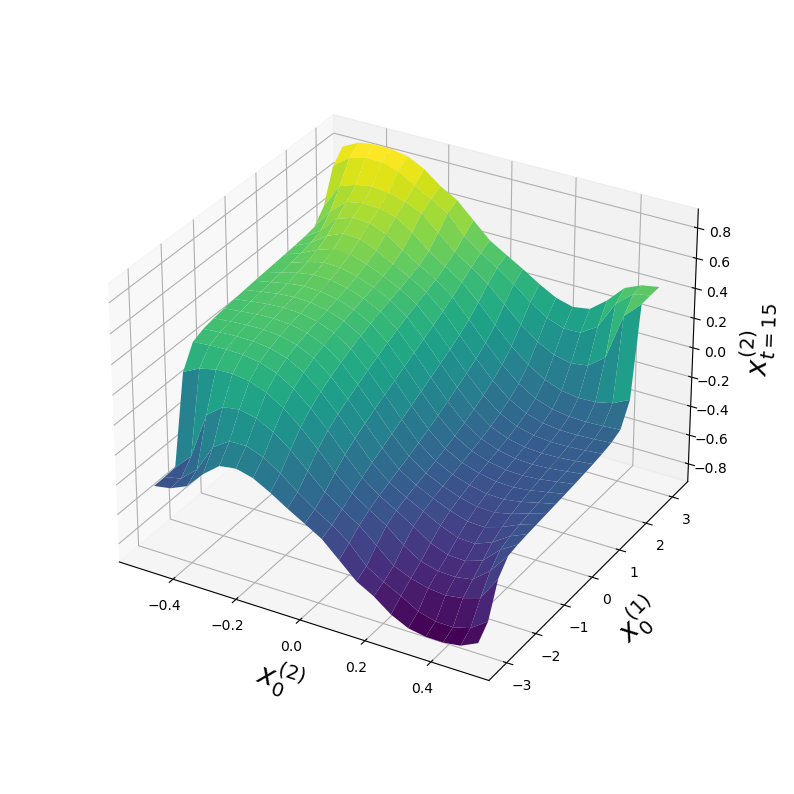

In [62]:
Ts = 0.03
beta = 0.5
g = 0.5
u_max = 10
x_max = np.array([np.pi, 0.5])
u_min = - u_max
x_min = - x_max

initial_state = x_max
system = DoubleIntegratorWithDrag(Ts=Ts, beta=beta, g=g, u_max=u_max, u_min=u_min, init_state=initial_state)

np.random.seed(0)

io_data_test = IOData(depth = 2, sys=system, length=100, input_rule=InputRule.RANDOM)
print(io_data_test._input_data[0].shape)
print(io_data_test._output_data[0].shape)
# plt.plot([y[0,0] for y in io_data_test._output_data], [y[1,0] for y in io_data_test._output_data])
# plt.xlabel("x")
# plt.ylabel("dot_x")

# draw the x^{(2)}(t+1) as a function of x(t)
N_1 = 20
N_2 = 20
u_applied = np.matrix('0')
x_1_list = np.linspace(x_min[0], x_max[0], N_1)
x_2_list = np.linspace(x_min[1], x_max[1], N_2)
x_1_mesh, x_2_mesh = np.meshgrid(x_1_list, x_2_list)

x_2_t_plus_1 = np.zeros((N_1, N_2))
fun = cas.Function('fun', [system._x, system._u], [system._f])
for i in range(N_1):
    for j in range(N_2):
        x_t = np.matrix([[x_1_list[i]], [x_2_list[j]]])
        system.state = np.array(x_t).flatten()
        for _ in range(15):
            y_t = system.step(u_applied)[0]
        y_t = system.step(u_applied)[0]
        x_2_t_plus_1[i, j] = y_t[1,0]
        # x_2_fun = fun(np.array([[x_1_list[i]], [x_2_list[j]]]), np.array(u_applied).flatten())
        # x_2_t_plus_1[i, j] = x_2_fun[1]
# from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=(10,14)).add_subplot(projection='3d')
ax.plot_surface(x_2_mesh, x_1_mesh, x_2_t_plus_1, cmap='viridis', edgecolor='none')
ax.set_xlabel('\n $x^{(2)}_{0}$', fontsize=20)
ax.set_ylabel('\n $x^{(1)}_{0}$', fontsize=20)
ax.set_zlabel('\n $x^{(2)}_{t=15}$', fontsize=20)
ax.set_box_aspect(aspect=None, zoom=0.85)


Text(0, 0.5, '$x_2$')

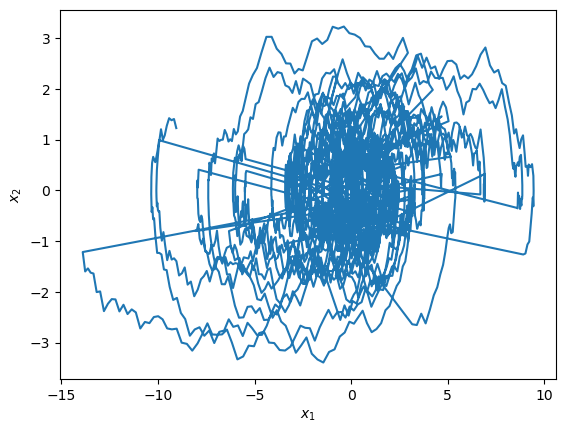

In [63]:
N_grid_x_0_data = 10
N_grid_x_1_data = 4

N_grid_x_0 = 10
N_grid_x_1 = 10
N_grid_u = 10

# x_0_grid_data = np.linspace(1.1*x_min[0], 1.1*x_max[0], N_grid_x_0_data)
# x_1_grid_data = np.linspace(1.1*x_min[1], 1.1*x_max[1], N_grid_x_1_data)
x_0_grid_data = np.linspace(x_min[0], x_max[0], N_grid_x_0_data)
x_1_grid_data = np.linspace(x_min[1], x_max[1], N_grid_x_1_data)

# x_0_grid = np.linspace(0.8*x_min[0], 0.8*x_max[0], N_grid_x_0)
# x_1_grid = np.linspace(0.8*x_min[1], 0.8*x_max[1], N_grid_x_1)
x_0_grid = np.linspace(x_min[0], x_max[0], N_grid_x_0)
x_1_grid = np.linspace(x_min[1], x_max[1], N_grid_x_1)
u_grid = np.linspace(u_min, u_max, N_grid_u)

d_range = 0.1
num_slices = 1
portion_slices = 0.0001
L = 15
W_x = np.diag((1/(x_max - x_min))**2)
# f = lambda d: (1/(d_range+d)) ** 2
f = lambda d: np.exp(-2*d)

np.random.seed(0)

length_list = np.array([100, 120, 140, 160, 180, 200, 250, 300, 500])
diff_list = np.diff(length_list)
io_data_list_list: List[List[IOData]] = []
io_data_list = []
for x_0, x_1 in itertools.product(x_0_grid_data, x_1_grid_data):
    # print(x_0, x_1)
    system_for_data = deepcopy(system)
    system_for_data.state = np.array([x_0, x_1])
    io_data_list.append(IOData(depth=2, sys=system_for_data, length=length_list[0], input_rule=InputRule.RANDOM))
io_data_list_list.append(deepcopy(io_data_list))

for diff_length in diff_list:
    io_data_list = deepcopy(io_data_list_list[-1])
    for io_data in io_data_list:
        # set the state and step the system for one step
        system_for_data.state = np.array(io_data._output_data[-1]).flatten()
        system_for_data.step(io_data._input_data[-1])

        # step the system and add new data
        for _ in range(diff_length):
            u = io_data.get_input(io_data.length-1, system_for_data, InputRule.RANDOM)
            y, n = system_for_data.step(u)
            io_data.add_point(u, y, n)
    io_data_list_list.append(deepcopy(io_data_list))
        

predictor = Predictor(L=1, system=system, io_data_list=io_data_list_list[0], remove_old_data=False, d_range=d_range)
predictor.min_num_slices = num_slices
predictor.portion_slices = portion_slices
H_x_past, H_u_future, H_x_future = predictor.get_hankel_matrix()
plt.plot(H_x_past[0,:].T, H_x_past[1,:].T)
# plt.xlim(x_min[0]-0.1*(x_max[0]-x_min[0]), x_max[0]+0.1*(x_max[0]-x_min[0]))
# plt.ylim(x_min[1]-0.1*(x_max[1]-x_min[1]), x_max[1]+0.1*(x_max[1]-x_min[1]))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

(-3.0, 3.0)

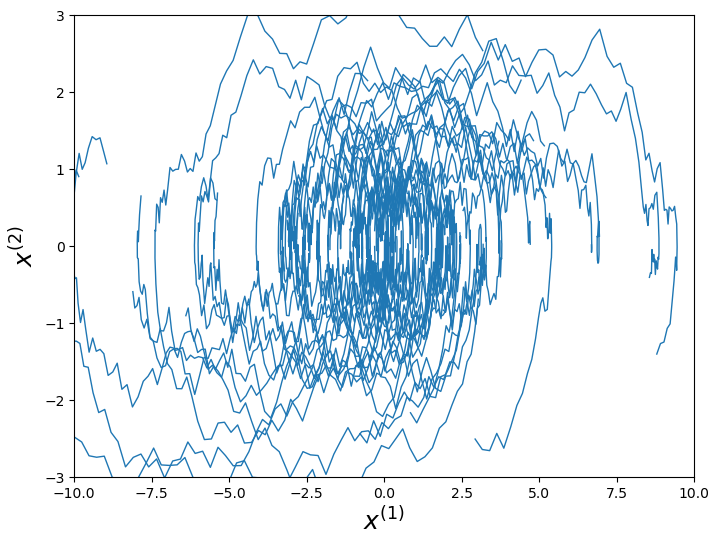

In [64]:
from tools.FractalDimension import plot_locs_list

data_list_to_plot = io_data_list_list[0]
locs_list = [np.array(np.hstack(io_data._output_data).T) for io_data in data_list_to_plot]

fig, ax = plt.subplots(figsize = (8,6))
for locs in locs_list:
    ax.plot(locs[:,0], locs[:,1], color = "tab:blue", linewidth = 1)
ax.set_xlabel("$x^{(1)}$", fontsize = 18)
ax.set_ylabel("$x^{(2)}$", fontsize = 18)
ax.set_xlim((-10,10))
ax.set_ylim((-3,3))

In [65]:
predictor.weight_xi = W_x
predictor.f = f

predictor.L = L
error_list_list: List[np.ndarray] = []
plain_error_list_list: List[np.ndarray] = []
for length, io_data_list in zip(length_list, io_data_list_list):
    error_list = np.zeros((N_grid_x_0, N_grid_x_1, N_grid_u, L))
    plain_error_list = np.zeros((N_grid_x_0, N_grid_x_1, N_grid_u, L))
    print("length: ", io_data_list[0].length)
    predictor.io_data_list = io_data_list
    for i, j, k in itertools.product(range(N_grid_x_0), range(N_grid_x_1), range(N_grid_u)):
        x_0 = x_0_grid[i]
        x_1 = x_1_grid[j]
        u = u_grid[k]
        x_t = np.matrix([[x_0], [x_1]])
        u_future = [np.matrix([[u]]) for _ in range(predictor.L)]

        predictor.d_range = d_range
        predictor.f = f
        error_list[i,j,k] = predictor.prediction_error(x_t, u_future, W_x)

        predictor.f = lambda d: 0.01
        predictor.d_range = np.inf
        u_future = [np.matrix([[u]]) for _ in range(predictor.L)]
        plain_error_list[i,j,k] = predictor.prediction_error(x_t, u_future, W_x)

    print("Average of Error", np.average(np.sum(error_list, axis=-1).flatten()))
    print("Maximum of Error", np.max(np.sum(error_list, axis=-1).flatten()))
    print("Average of Plain Error", np.average(np.sum(plain_error_list, axis=-1).flatten()))
    print("Maximum of Plain Error", np.max(np.sum(plain_error_list, axis=-1).flatten()))
    error_list_list.append(error_list)
    plain_error_list_list.append(plain_error_list)

length:  100


KeyboardInterrupt: 

In [ ]:
import pickle
import datetime

time = f"{datetime.datetime.now():%m-%d-%H-%M-%S}"
file_name = time + "-" + "with_weight.pkl"

with open(os.path.join(os.getcwd(), 'datasets', file_name), 'wb') as f:
    pickle.dump(error_list_list, f)

file_name = time + "-" + "without_weight.pkl"

with open(os.path.join(os.getcwd(), 'datasets', file_name), 'wb') as f:
    pickle.dump(plain_error_list_list, f)


In [66]:
read_file = True
if read_file:
    file_with_weight = "10-31-12-48-02-with_weight.pkl"
    file_without_weight = "10-31-12-48-02-without_weight.pkl"
    with open(os.path.join(os.getcwd(), 'datasets', file_with_weight), 'rb') as f:
        error_list_list = pickle.load(f)
    with open(os.path.join(os.getcwd(), 'datasets', file_without_weight), 'rb') as f:
        plain_error_list_list = pickle.load(f)

Text(0.5, 1.0, 'Prediction Error without Weighting Method')

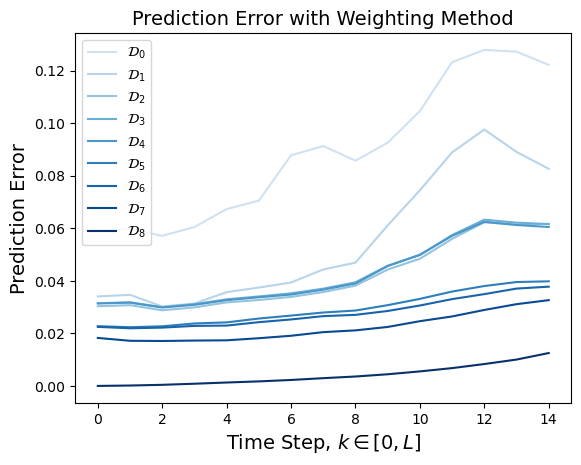

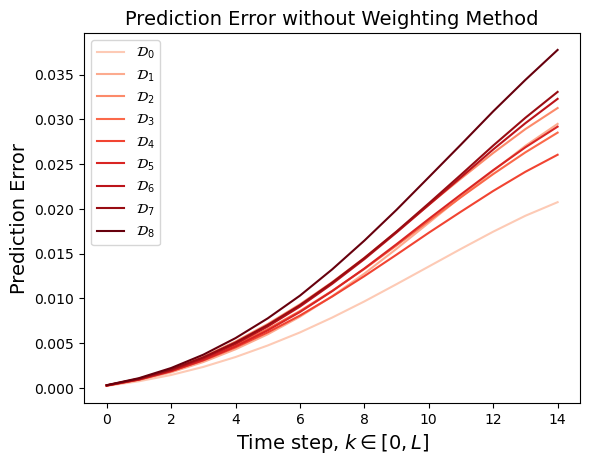

In [67]:

n_datasets = len(error_list_list)
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(len(error_list_list)):
    print
    average_error = np.average(error_list_list[i], axis=(0,1,2))
    ax.plot(average_error, color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")
    # ax.plot(average_error, label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time Step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Weighting Method", fontsize=14)

colors_without_weight = plt.cm.Reds(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(len(plain_error_list_list)):
    average_error = np.average(plain_error_list_list[i], axis=(0,1,2))
    ax.plot(average_error, color=colors_without_weight[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error without Weighting Method", fontsize=14)

Text(0.5, 1.0, 'Prediction Error with Rich Enough Dataset')

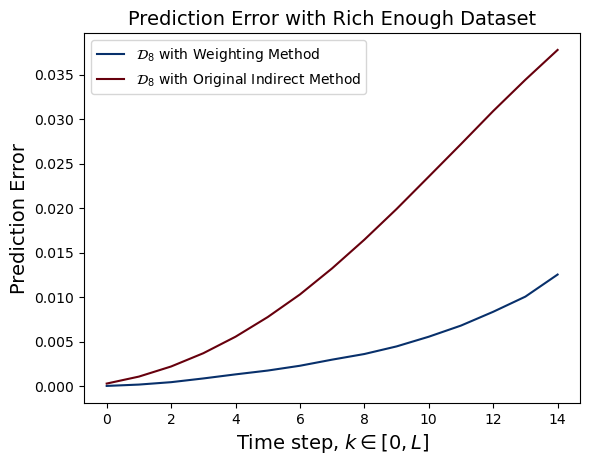

In [68]:
fig, ax = plt.subplots()

average_error = np.average(error_list_list[-1], axis=(0,1,2))
ax.plot(average_error, color=colors_for_datasets[-1], label=f"$\mathcal{{D}}_{len(error_list_list)-1}$ with Weighting Method")
# ax.plot(average_error[0:4], color=colors_for_datasets[-1], label=f"$\mathcal{{D}}_{len(error_list_list)-1}$ With Weighting Method")

color_without_weight = plt.cm.Reds(np.linspace(0.2, 1, n_datasets))
average_error = np.average(plain_error_list_list[-1], axis=(0,1,2))
ax.plot(average_error, color=color_without_weight[-1], label=f"$\mathcal{{D}}_{len(error_list_list)-1}$ with Original Indirect Method")
# ax.plot(average_error[0:4], color=color_without_weight[-1], label=f"$\mathcal{{D}}_{len(error_list_list)-1}$ Without Weighting Method")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Rich Enough Dataset", fontsize=14)

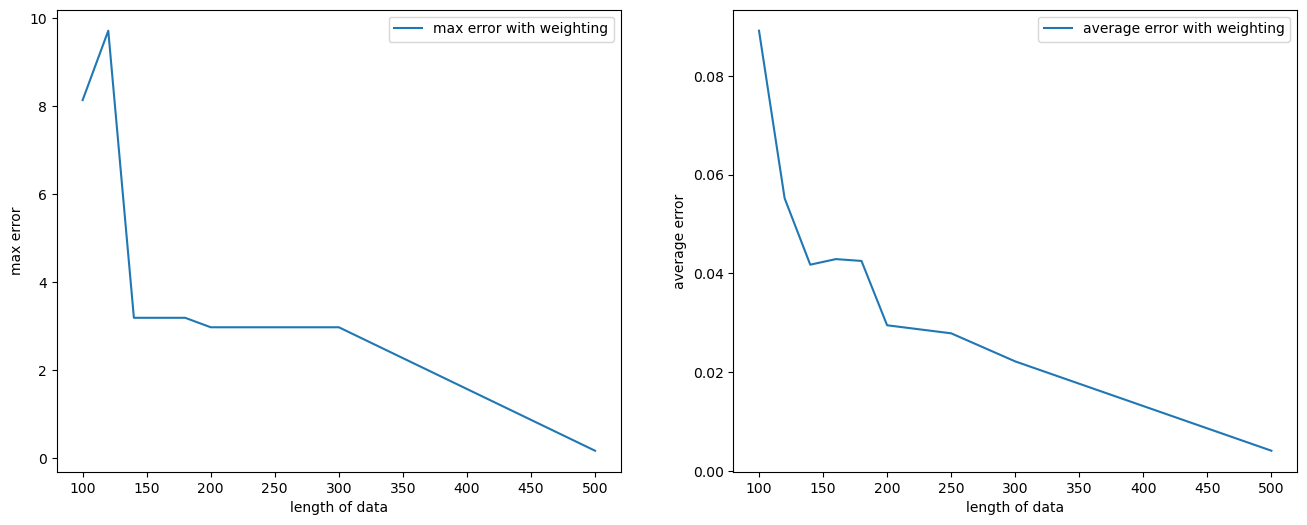

In [69]:
max_error_list = np.zeros((len(length_list),))
max_plain_error_list = np.zeros((len(length_list),))
average_error_list = np.zeros((len(length_list),))
average_plain_error_list = np.zeros((len(length_list),))
for i in range(len(length_list)):
    max_error_list[i] = np.max(error_list_list[i].flatten())
    max_plain_error_list[i] = np.max(plain_error_list_list[i].flatten())
    average_error_list[i] = np.average(error_list_list[i].flatten())
    average_plain_error_list[i] = np.average(plain_error_list_list[i].flatten())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(length_list, max_error_list, label="max error with weighting")
# ax[0].plot(length_list, max_plain_error_list, label="max error without weighting")
ax[0].set_xlabel("length of data")
ax[0].set_ylabel("max error")
ax[0].legend()

ax[1].plot(length_list, average_error_list, label="average error with weighting")
# ax[1].plot(length_list, average_plain_error_list, label="average error without weighting")
ax[1].set_xlabel("length of data")
ax[1].set_ylabel("average error")
ax[1].legend()

[-0.59998176 -0.69701161 -0.61227143]
[0.60001824 0.50298839 0.58772857]
(4000, 3)
[-0.59998176 -0.70458573 -0.61227143]
[0.60001824 0.49541427 0.58772857]
(4800, 3)
[-0.59998176 -0.70458573 -0.54148469]
[0.60001824 0.49541427 0.65851531]
(5600, 3)


KeyboardInterrupt: 

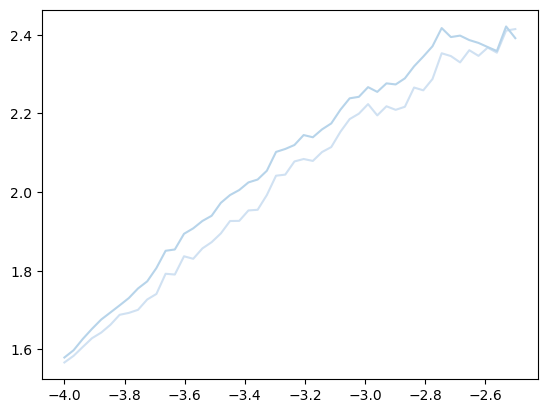

In [70]:
# dimension of whole shape
io_data_list = io_data_list_list[0]
sublist = io_data_list_list
# sublist = [io_data_list]

size_min = -4.5
size_max = -2.0
N_size_step = 50
size_length = 1.0
n_sample = 15
n_offset = 15

middle_points = np.linspace(size_max-size_length/2, size_min+size_length/2, N_size_step)
size_ranges = [(middle_point + size_length/2, middle_point - size_length/2) for middle_point in middle_points]
d_list_list = []

fig, ax = plt.subplots()
for i, io_data_list in enumerate(sublist):
    H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
    # print(H_ux[:,0:2])
    locs = np.array(H_ux.T) # normalize data
    # print(locs[0:2,:])

    # region_min = np.hstack([u_min, x_min])
    # region_max = np.hstack([u_max, x_max])
    region_min = np.min(locs, axis=0)
    region_max = np.max(locs, axis=0)
    mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
    locs = locs[mask]

    region_size = region_max - region_min
    region_min = region_min - 0.1 * region_size
    region_max = region_max + 0.1 * region_size

    region_min = region_min/region_size
    region_max = region_max/region_size
    locs = locs/region_size
    print(region_min)
    print(region_max)
    print(locs.shape)
    d_list = []
    for size_range in size_ranges:
        # print(size_range)
        d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=size_range[0], min_box_size=size_range[1], n_samples=n_sample, n_offsets=n_offset, plot=False)
        d_list.append(d)
    if False:
        ax.plot(middle_points, d_list, label=f"$\mathcal{{D}}_{i}$")
    else: 
        ax.plot(middle_points, d_list, color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")
        # ax.plot(middle_points, d_list, color=colors_for_datasets[-1], label=f"$\mathcal{{D}}_{i}$")
    d_list_list.append(d_list)
ax.set_ylim(1.5, 2.8)
ax.legend()
ax.set_ylabel(r"Fitted box-counting dimension", fontsize=14)
ax.set_xlabel(r"Middle point of box-size range (log scale)", fontsize=14)


40
100
[-11.99833415 -16.33887823  -4.05672001]
[11.99906351 11.790716    3.89410666]
[19.99783138 23.44132852  6.6256889 ]
[-0.59998176 -0.69701161 -0.61227143]
[0.60001824 0.50298839 0.58772857]
(4000, 3)
1.8883546979110557


Text(0.5, 0, '$\\log_2 \\frac{1}{\\epsilon}$')

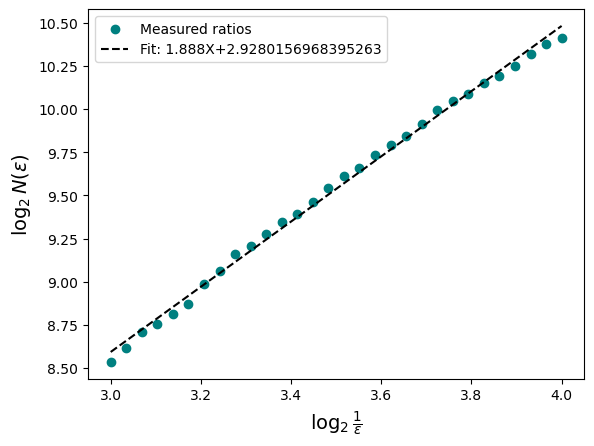

In [73]:
from tools.FractalDimension import plot_locs_list, plot_squares, fractal_dimension
from tools.dataset_analyse import get_datasets_hankel_matrix_list

H_ux_list, _ = get_datasets_hankel_matrix_list(io_data_list, 1, 0)
locs_list = [np.array(H_ux.T) for H_ux in H_ux_list]

io_data_list = io_data_list_list[0]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size
print(region_min)
print(region_max)
print(region_size)

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
locs_list = [sublocs/region_size for sublocs in locs_list]
print(region_min)
print(region_max)
print(locs.shape)
fig, ax = plt.subplots()
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-3, min_box_size=-4.0, n_samples=30, n_offsets=30, plot=True, plot_fitting=True, ax=ax)
print(d)
ax.set_ylabel(r"$\log_2 N(\epsilon)$", fontsize=14)
ax.set_xlabel(r"$\log_2 \frac{1}{\epsilon}$", fontsize=14)

[-0.59998176 -0.69701161 -0.61227143]
[0.60001824 0.50298839 0.58772857]


Text(0, 0.5, '$x^{(2)}$')

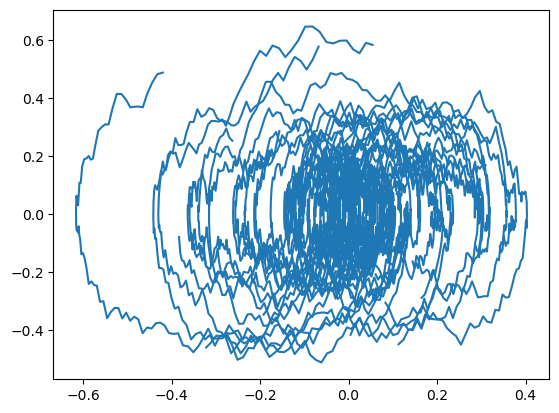

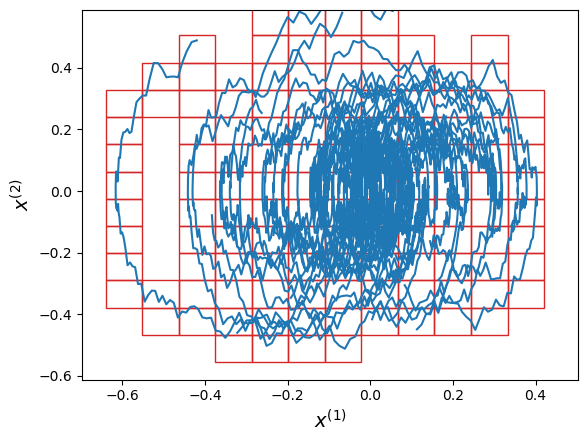

In [75]:
fig, ax = plt.subplots()
for locs in locs_list:
        ax.plot(locs[:,1], locs[:,2], color = "tab:blue")

print(region_min)
print(region_max)
fig, ax = plt.subplots()
plot_squares(locs_list=locs_list, scale=-3.5, region_max=region_max, region_min=region_min, n_offsets=40, axis = [1,2], ax=ax)
ax.set_xlabel("$x^{(1)}$", fontsize=14)
ax.set_ylabel("$x^{(2)}$", fontsize=14)

40
120
[ -9.99855101 -14.44376145  -3.39415112]
[0.60001824 0.49541427 0.58772857]
(4800, 3)
2.2449798166342676


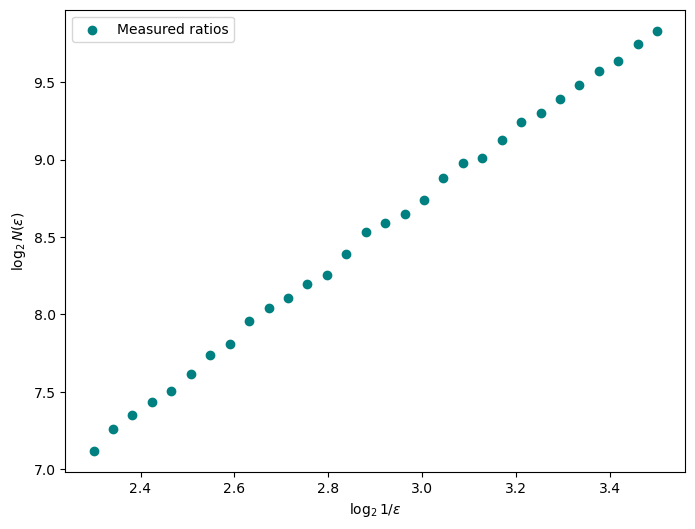

In [ ]:
io_data_list = io_data_list_list[1]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3.5, n_samples=30, n_offsets=20, plot=True)
print(d)

40
140
[ -9.99855101 -14.44376145  -3.39415112]
[0.60001824 0.49541427 0.65851531]
(5600, 3)
2.275755064217043


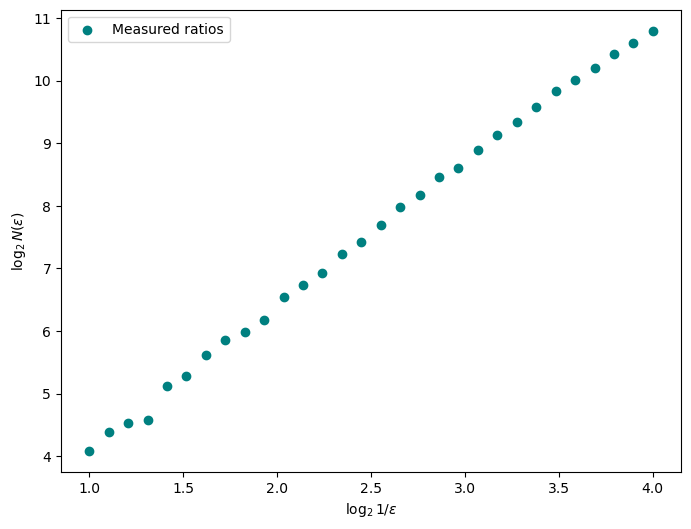

In [ ]:
io_data_list = io_data_list_list[2]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-1, min_box_size=-4, n_samples=30, n_offsets=20, plot=True)
print(d)

40
160
[ -9.99855101 -14.44376145  -4.00121942]
[0.60001824 0.49541427 0.62683458]
(6400, 3)
2.2983680150244172


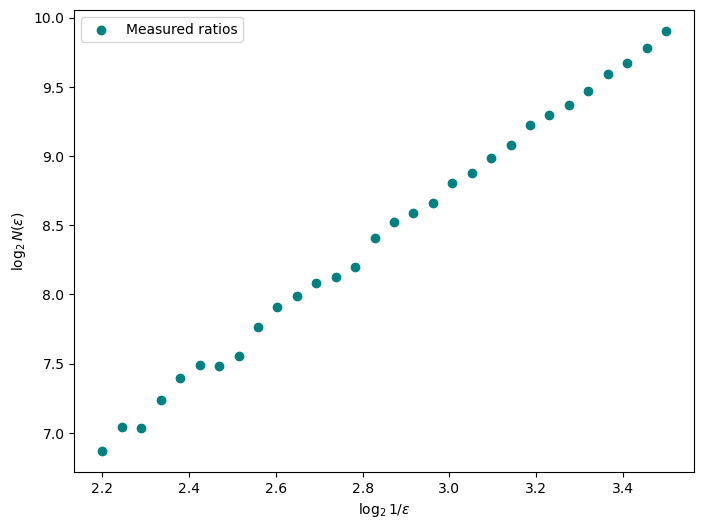

In [ ]:
io_data_list = io_data_list_list[3]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.2, min_box_size=-3.5, n_samples=30, n_offsets=20, plot=True)
print(d)

40
180
[ -9.99855101 -14.44376145  -4.00121942]
[0.60001824 0.61768135 0.63202999]
(7200, 3)
2.334163906427109


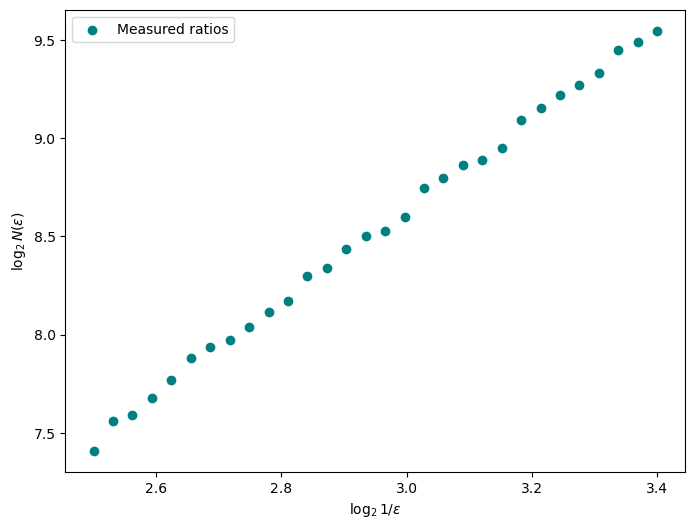

In [ ]:
io_data_list = io_data_list_list[4]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.4, n_samples=30, n_offsets=20, plot=True)
print(d)

40
200
[ -9.99855101 -15.87768584  -4.00121942]
[0.60001824 0.63455376 0.63202999]
(8000, 3)
2.292316637491608


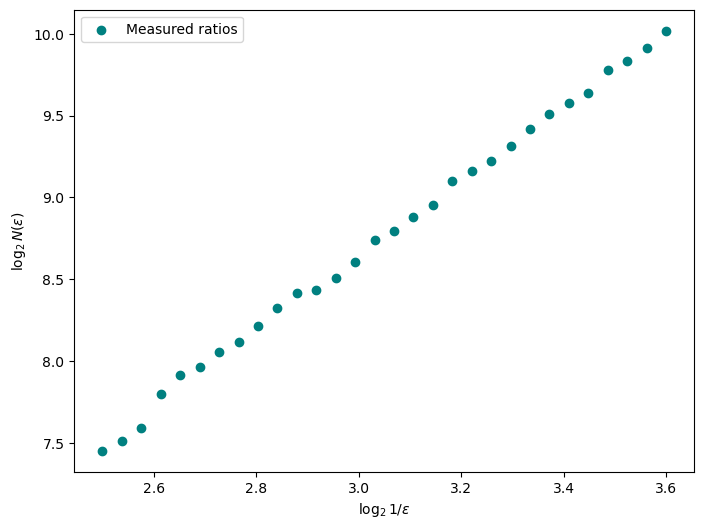

In [ ]:
io_data_list = io_data_list_list[5]
print(len(io_data_list))
print(io_data_list[0].length)
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

# region_min = np.hstack([u_min, x_min])
# region_max = np.hstack([u_max, x_max])
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.6, n_samples=30, n_offsets=20, plot=True)
print(d)

[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1141, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1257, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1308, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1387, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1419, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1434, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1487, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1575, 3)
[-0.6 -0.6 -0.6]
[0.6 0.6 0.6]
(1796, 3)


Text(0.5, 0, 'Middle point of box-size range (log scale)')

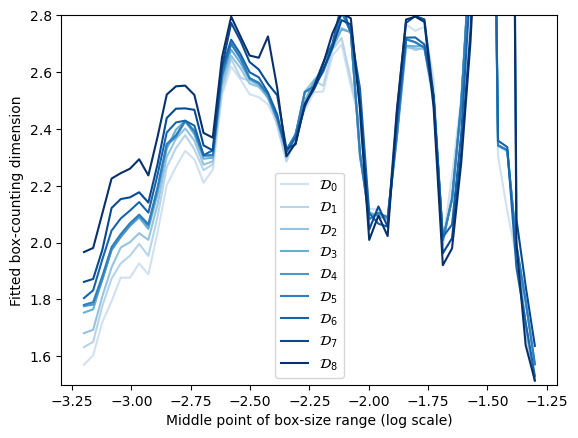

In [ ]:
# dimension within region
size_min = -3.5
size_max = -1
N_size_step = 50
size_length = 0.6
n_sample = 15
n_offset = 15

middle_points = np.linspace(size_max-size_length/2, size_min+size_length/2, N_size_step)
size_ranges = [(middle_point + size_length/2, middle_point - size_length/2) for middle_point in middle_points]
d_list_list = []

fig, ax = plt.subplots()
for i, io_data_list in enumerate(io_data_list_list):
    H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
    # print(H_ux[:,0:2])
    locs = np.array(H_ux.T) # normalize data
    # print(locs[0:2,:])

    region_min = np.hstack([u_min, x_min])
    region_max = np.hstack([u_max, x_max])
    # region_min = np.min(locs, axis=0)
    # region_max = np.max(locs, axis=0)
    mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
    locs = locs[mask]

    region_size = region_max - region_min
    region_min = region_min - 0.1 * region_size
    region_max = region_max + 0.1 * region_size

    region_min = region_min/region_size
    region_max = region_max/region_size
    locs = locs/region_size
    print(region_min)
    print(region_max)
    print(locs.shape)
    d_list = []
    for size_range in size_ranges:
        # print(size_range)
        d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=size_range[0], min_box_size=size_range[1], n_samples=n_sample, n_offsets=n_offset, plot=False)
        d_list.append(d)
    ax.plot(middle_points, d_list, color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")
    d_list_list.append(d_list)
ax.set_ylim(1.5, 2.8)
ax.legend()
ax.set_ylabel(r"Fitted box-counting dimension")
ax.set_xlabel(r"Middle point of box-size range (log scale)")

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1141, 3)
2.387348156273452


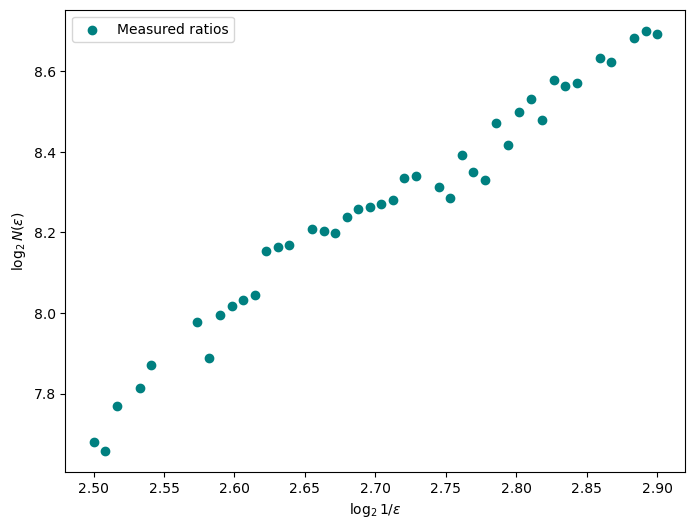

In [ ]:
io_data_list = io_data_list_list[0]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-2.9, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1257, 3)
2.2701984895433385


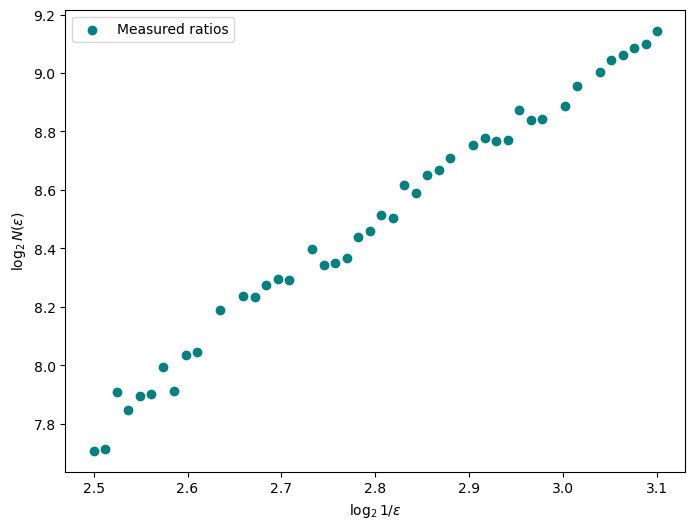

In [ ]:
io_data_list = io_data_list_list[1]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3.1, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1308, 3)
2.2904138107586784


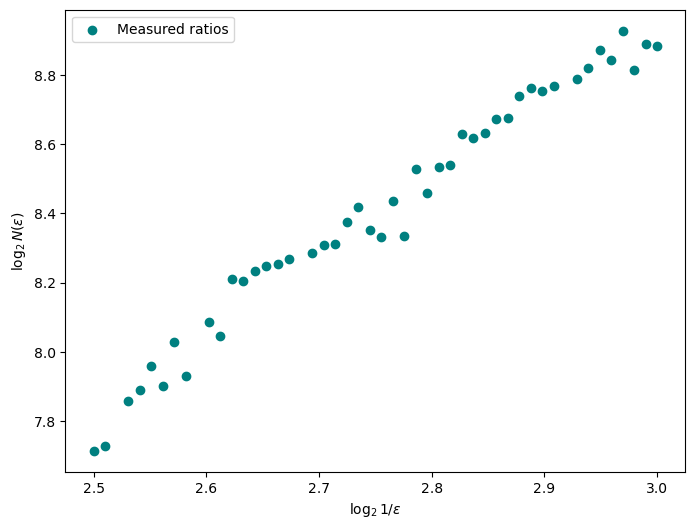

In [ ]:
io_data_list = io_data_list_list[2]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1387, 3)
2.3289868610224183


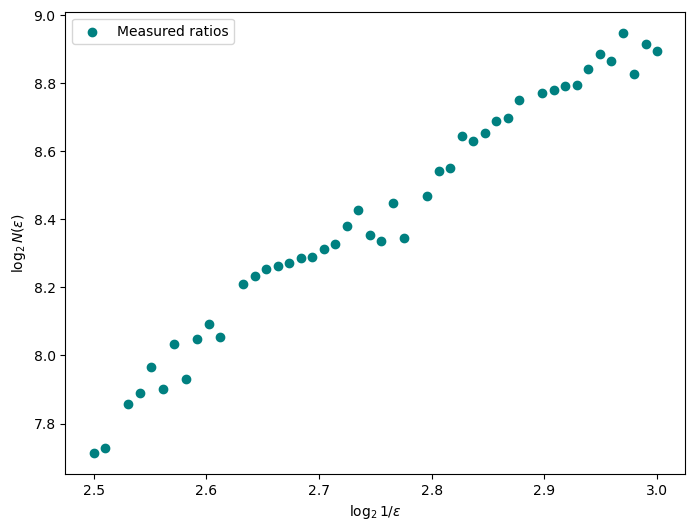

In [ ]:
io_data_list = io_data_list_list[3]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.5, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1419, 3)
2.3362626537756053


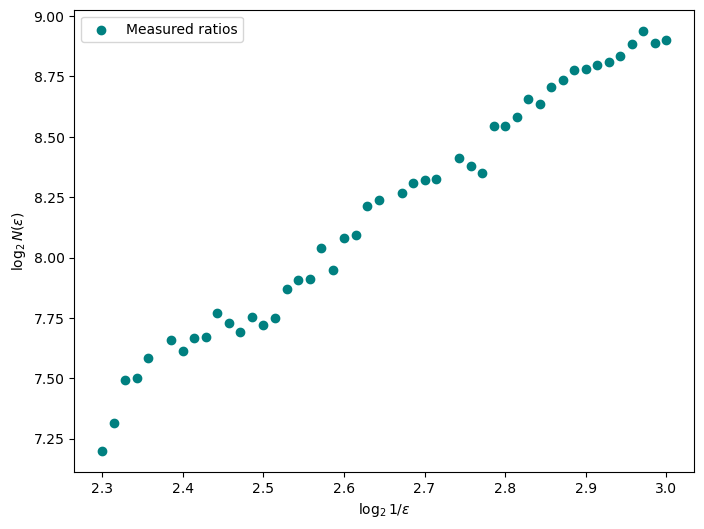

In [ ]:
io_data_list = io_data_list_list[4]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)

[-10.          -3.14159265  -0.5       ]
[0.6 0.6 0.6]
(1434, 3)
2.335951960346392


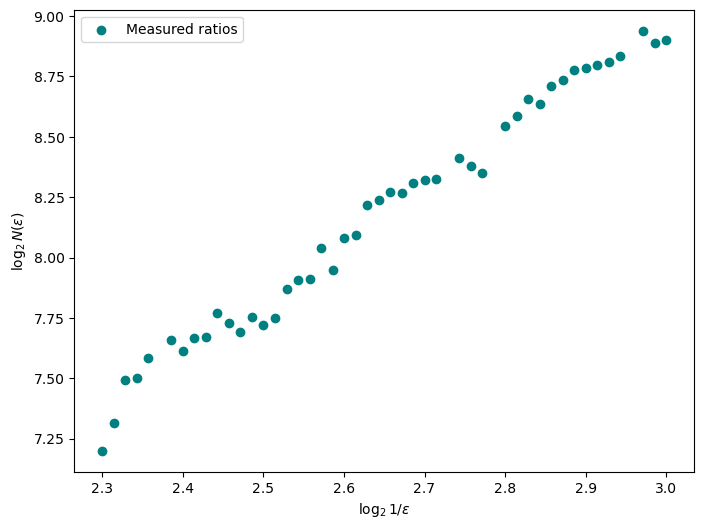

In [ ]:
io_data_list = io_data_list_list[5]
H_ux, _ = get_datasets_hankel_matrix(io_data_list, 1, 0)
# print(H_ux[:,0:2])
locs = np.array(H_ux.T) # normalize data
# print(locs[0:2,:])

region_min = np.hstack([u_min, x_min])
region_max = np.hstack([u_max, x_max])
# region_min = np.min(locs, axis=0)
# region_max = np.max(locs, axis=0)
mask = np.all((locs >= region_min) & (locs <= region_max), axis=1)
locs = locs[mask]

region_size = region_max - region_min
region_min = region_min - 0.1 * region_size
region_max = region_max + 0.1 * region_size

region_min = region_min/region_size
region_max = region_max/region_size
locs = locs/region_size
print(region_min)
print(region_max)
print(locs.shape)
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-2.3, min_box_size=-3, n_samples=50, n_offsets=30, plot=True)
print(d)